in this notebook, we will be simplifying some of the common techniques used in Captum for interpreting BERT<br>
We will start with a simple Neural Network and then proceed to  Integrated Gradients. There are 3 sections:
    1. Using Intergrated gradients from Captum Library
    2. Writing a simplified version of Intergrated Gradients
    3. Expanding the library function from captum without bells & whistles <br>
The results from all the 3 methods can be found in the last cell

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
import numpy as np
from captum.attr import IntegratedGradients
from IPython.display import Image

##  Simple Neural Net

In [2]:
class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN,self).__init__()
        self.input_linear = nn.Linear(in_features=3,out_features=3,bias=True) # takes 2 features and outputs 3 
        self.hidden= nn.Linear(in_features=3,out_features=2,bias=True) #one output for each class

        
    def forward(self,x):
        x = F.relu(self.input_linear(x))
        x= torch.sigmoid(self.hidden(x))
        x = F.softmax(x,dim=1)
        return x

### Data & parameters

In [3]:
inData = torch.tensor([[ 0.5, 0.3,0.6]],requires_grad=True) # shape is [1,3] Imagine this to be a word with 3 dimensional vector [batch_size,num_dim]
baseline = torch.tensor([[ 0.3, 0.7,0.2]],requires_grad=True)
target_index = 1 # index of second class
num_steps = 10

### Running Intergrated Gradients from Captum

In [4]:
def predict_i(inputs):
    logits = net(inputs) # I cant pass the model itself as a parameter to IntegratedGradients
    return logits

In [5]:
net = simpleNN()

In [6]:
# passing this to Integrated Gradients method
ig = IntegratedGradients(forward_func=predict_i)

In [7]:
attributions_summary = ig.attribute(inputs=(inData),
                                  baselines=(baseline),
                                   n_steps=num_steps,
                                   target =target_index)
print("Attributions associated with each dimension of the word are")
for att in attributions_summary[0]:
    print("\t", round(att.item(),5))

Attributions associated with each dimension of the word are
	 0.0015
	 0.00244
	 -0.00217


### Simplified Intergrated Gradients

Next we will recreate the results in understandable terms.  We start with creating 10 vectors which lie between input and baseline

In [8]:
dim1 = torch.linspace(0, 1, num_steps).unsqueeze(-1) #[10, 1] i.e 10 columns , equally spaced points between 0 & 1
#10 points between zero & 1. we stack it vertically thrice because each datapoint has 3 dimensions
points = torch.cat((dim1,dim1,dim1),1).float() # [10, 3] [batch_size,dim]

In [9]:
delta_points_np = (baseline + points * (inData - baseline)).detach().numpy() #(10, 3)
print("In the data points shown below , first row is the baseline and last row is the input Data")
print(delta_points_np)

In the data points shown below , first row is the baseline and last row is the input Data
[[0.3        0.7        0.2       ]
 [0.32222223 0.65555555 0.24444446]
 [0.34444445 0.6111111  0.2888889 ]
 [0.36666667 0.56666666 0.33333337]
 [0.3888889  0.5222222  0.3777778 ]
 [0.41111112 0.47777778 0.42222226]
 [0.43333334 0.43333334 0.4666667 ]
 [0.45555556 0.3888889  0.51111114]
 [0.47777778 0.34444445 0.5555556 ]
 [0.5        0.3        0.6       ]]


#### Implementing Intergrated Gradients formula

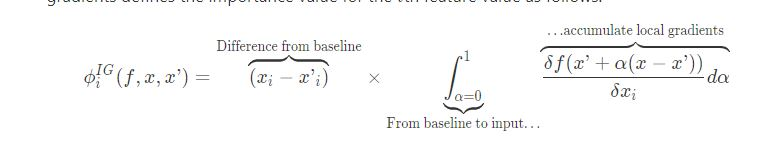

In [10]:
Image("Images/ig.JPG")

We will start with accumulating gradients in the second part of the formula

#### Compute gradients for these 10 points 

In [11]:
gradient_l = []
count = 0
for row in delta_points_np:
    delta_input = torch.tensor([row],requires_grad=True)
    delta_output = net(delta_input) #[1, 2] [batch_size,num_classes]
    target = delta_output[0][target_index].unsqueeze(-1) #[1] taking the 
 
    # Now compute gradients of the input with respect to the output:
    d_loss_dx = grad(outputs=target, inputs=delta_input) # it is a tuple of which first element is gradient of delta_input
    gradient_l.append(d_loss_dx[0])

We are creating a function that takes in a list of gradient tensors and returns the mean

In [12]:
def getTensorMean(TensorList):
    tensor_2D = torch.stack(TensorList)
    return torch.mean(tensor_2D,axis=0)

In [13]:
gradient_l_mean = getTensorMean(gradient_l)
print("The means of gradients of 10 vectors between input and baseline")
gradient_l_mean

The means of gradients of 10 vectors between input and baseline


tensor([[ 0.0075, -0.0061, -0.0054]])

Next we take the difference between input and baseline. This is a straight line between input and baseline

In [14]:
diff = (inData-baseline)
diff

tensor([[ 0.2000, -0.4000,  0.4000]], grad_fn=<SubBackward0>)

Multiplying it by the difference of the gradients

In [15]:
attributions = gradient_l_mean * diff
print("Attributions from simplified version of the code")
for att in attributions[0]:
    print("\t", round(att.item(),5))

Attributions from simplified version of the code
	 0.0015
	 0.00244
	 -0.00217


The above attributions are close to the ones from the library in **cell 22**. Next we can expand the library code in the section below to understand what the library does

### Expanded Library Code

Instead of taking equally spaced points , we generate these points with gausian legrande function

#### Preparing Datapoints and target vectors 

In [16]:
step_sizes = list(0.5 * np.polynomial.legendre.leggauss(num_steps)[1])
alphas = list(0.5 * (1 + np.polynomial.legendre.leggauss(num_steps)[0]))

In [17]:
print("Equally spaced")
print (dim1)

Equally spaced
tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]])


In [18]:
print("gausian legrande function")
print(alphas)

gausian legrande function
[0.013046735741414128, 0.06746831665550773, 0.16029521585048778, 0.2833023029353764, 0.4255628305091844, 0.5744371694908156, 0.7166976970646236, 0.8397047841495122, 0.9325316833444923, 0.9869532642585859]


Creating 10 points between input and baseline

In [19]:
delta_points =torch.cat([baseline + alpha * (inData - baseline) for alpha in alphas],dim=0).requires_grad_() #[10,3]

We will create a tensor for the required target class as follows : 

In [20]:
target = torch.cat(num_steps* [torch.tensor([target_index])]) #[num_steps] [10]
target = target.reshape(num_steps, 1) #[num_steps,1] [10, 1]

In [21]:
target

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

#### Running through Ig

Let's get the probability of target class occuring in each of the 10 vectors 

In [22]:
output = net(delta_points)
target_Dp = torch.gather(output, 1, target)
assert target_Dp[0].numel() == 1
target_Dp

tensor([[0.5175],
        [0.5176],
        [0.5178],
        [0.5180],
        [0.5183],
        [0.5185],
        [0.5188],
        [0.5190],
        [0.5192],
        [0.5193]], grad_fn=<GatherBackward>)

Obtaining gradients of the output with respect to the input

In [23]:
grads = torch.autograd.grad(torch.unbind(target_Dp), delta_points) # torch.unbind removes one dimension

In [24]:
print("The gradient we calculated in simplified version")
gradient_l

The gradient we calculated in simplified version


[tensor([[ 0.0076, -0.0062, -0.0055]]),
 tensor([[ 0.0076, -0.0062, -0.0055]]),
 tensor([[ 0.0076, -0.0061, -0.0055]]),
 tensor([[ 0.0075, -0.0061, -0.0055]]),
 tensor([[ 0.0075, -0.0061, -0.0054]]),
 tensor([[ 0.0075, -0.0061, -0.0054]]),
 tensor([[ 0.0075, -0.0061, -0.0054]]),
 tensor([[ 0.0074, -0.0060, -0.0054]]),
 tensor([[ 0.0074, -0.0060, -0.0054]]),
 tensor([[ 0.0074, -0.0060, -0.0054]])]

In [25]:
print("the gradient we calculated using library functions in cell 11")
grads

the gradient we calculated using library functions in cell 11


(tensor([[ 0.0076, -0.0062, -0.0055],
         [ 0.0076, -0.0062, -0.0055],
         [ 0.0076, -0.0061, -0.0055],
         [ 0.0076, -0.0061, -0.0055],
         [ 0.0075, -0.0061, -0.0054],
         [ 0.0075, -0.0061, -0.0054],
         [ 0.0075, -0.0061, -0.0054],
         [ 0.0074, -0.0060, -0.0054],
         [ 0.0074, -0.0060, -0.0054],
         [ 0.0074, -0.0060, -0.0054]]),)

scaled_grads seems to be smoothing the values by multiplying with step sizes

In [26]:
# flattening grads so that we can multilpy it with step-size
# calling contiguous to avoid `memory whole` problems
n_steps=10
scaled_grads = [
    grad.contiguous().view(n_steps, -1)
    * torch.tensor(step_sizes).view(n_steps, 1).to(grad.device)
    for grad in grads
]
scaled_grads

[tensor([[ 0.0003, -0.0002, -0.0002],
         [ 0.0006, -0.0005, -0.0004],
         [ 0.0008, -0.0007, -0.0006],
         [ 0.0010, -0.0008, -0.0007],
         [ 0.0011, -0.0009, -0.0008],
         [ 0.0011, -0.0009, -0.0008],
         [ 0.0010, -0.0008, -0.0007],
         [ 0.0008, -0.0007, -0.0006],
         [ 0.0006, -0.0004, -0.0004],
         [ 0.0002, -0.0002, -0.0002]], dtype=torch.float64)]

In [27]:
from torch import Tensor
from typing import Tuple
def _reshape_and_sum(
    tensor_input: Tensor, num_steps: int, num_examples: int, layer_size: Tuple[int, ...]
) -> Tensor:
    # Used for attribution methods which perform integration
    # Sums across integration steps by reshaping tensor to
    # (num_steps, num_examples, (layer_size)) and summing over
    # dimension 0. Returns a tensor of size (num_examples, (layer_size))
    print("layer_size",layer_size)
    print("num_examples",num_examples)
    print("num_steps",num_steps)
    return torch.sum(
        tensor_input.reshape((num_steps, num_examples) + layer_size), dim=0
    )

In [28]:
# aggregates across all steps for each tensor in the input tuple
# total_grads has the same dimensionality as inputs
total_grads = [
    _reshape_and_sum(
        tensor_input=scaled_grad, num_steps=n_steps, num_examples=grad.shape[0] // n_steps, layer_size=grad.shape[1:] # // is integer division
    )
    for (scaled_grad, grad) in zip(scaled_grads, grads)
]
print ("Total gradients after smoothing it out a bit")
for tg in total_grads[0][0]:
    print("\t",tg.item())

layer_size torch.Size([3])
num_examples 1
num_steps 10
Total gradients after smoothing it out a bit
	 0.0075060081458132085
	 -0.006091049426064586
	 -0.005426962098435991


In [29]:
print ("Comparing it with the mean we generated in cell 13")
for tg in gradient_l_mean[0]:
    print("\t",tg.item())

Comparing it with the mean we generated in cell 13
	 0.007505772169679403
	 -0.006090858019888401
	 -0.005426791496574879


In [30]:
# computes attribution for each tensor in input tuple
# attributions has the same dimensionality as inputs
attributions_expanded_code = tuple(
    total_grad * (input - base)
    for total_grad, input, base in zip(total_grads, inData, baseline)
)



In [31]:
print("Attributions from library code")
for att in attributions_summary[0]:
    print("\t", round(att.item(),5))

print("Attributions from simplified version of the code")
for att in attributions[0]:
    print("\t", round(att.item(),5))
    
print("attributions from expanding library code")
for att in attributions_expanded_code[0][0]:
    print("\t", round(att.item(),5))

Attributions from library code
	 0.0015
	 0.00244
	 -0.00217
Attributions from simplified version of the code
	 0.0015
	 0.00244
	 -0.00217
attributions from expanding library code
	 0.0015
	 0.00244
	 -0.00217


## Reference
1. https://distill.pub/2020/attribution-baselines/